In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os
import numpy as np
from collections import namedtuple
import cv2
from pathlib import Path
import argparse
import os
import csv
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras

# pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [4]:
### 실행결과 동일하게(완전 일치하지는 않음)
tf.keras.utils.set_random_seed(42)
### 텐서 연산 고정(완전 일치하지는 않음)
tf.config.experimental.enable_op_determinism()

In [5]:
# data = 원본데이터 | data2 = 우리가 측정한 데이터
folder_path_1 = "./data/이상(방화)"
folder_path_2 = "./data/이상(유기)"
folder_path_3 = "./data/이상(전도)"
folder_path_4 = "./data/이상(절도)"
folder_path_5 = "./data/이상(파손)"
folder_path_6 = "./data/이상(폭행)"
folder_path_7 = "./data/이상(흡연)"
#folder_path_7 = "./data/이상(교통약자)"
folder_path_8 = "./data/구매(구매)"
folder_path_9 = "./data/구매(반품)"
folder_path_10 = "./data/구매(비교)"
folder_path_11 = "./data/구매(선택)"

In [6]:
def concat(path):
    file_lst = os.listdir(path)
    df_list = []
    for file in file_lst:
        file_name = os.path.join(path, file)
        df = pd.read_csv(file_name)
        df = df[df.NUMOFBODIES != 0].reset_index(drop=True)
###
        if len(df) < 610:
            pad_length = 610 - len(df)
            pad_df = pd.DataFrame(0, index=range(len(df), 610), columns=df.columns)
            df = pd.concat([df, pad_df])
        df['index_num'] = df.index
###
        df_list.append(df)
    #concat_df = pd.concat(df_list, ignore_index=True)
    return df_list

In [7]:
file_lst = os.listdir(folder_path_1)

In [38]:
fire_mer = concat(folder_path_1)
yugi_mer = concat(folder_path_2)
jeon_mer = concat(folder_path_3)
theft_mer = concat(folder_path_4)
damage_mer = concat(folder_path_5)
violence_mer = concat(folder_path_6)
smoke_mer = concat(folder_path_7)
buy_mer = concat(folder_path_8)
refund_mer = concat(folder_path_9)
compar_mer = concat(folder_path_10)
select_mer = concat(folder_path_11)
#test_mer = pd.concat(test_mer, ignore_index=True)

In [39]:
buy_mer = pd.concat(buy_mer, ignore_index=True)
refund_mer = pd.concat(refund_mer, ignore_index=True)
compar_mer = pd.concat(compar_mer, ignore_index=True)
select_mer = pd.concat(select_mer, ignore_index=True)
fire_mer = pd.concat(fire_mer, ignore_index=True)
yugi_mer = pd.concat(yugi_mer, ignore_index=True)
jeon_mer = pd.concat(jeon_mer, ignore_index=True)
theft_mer = pd.concat(theft_mer, ignore_index=True)
damage_mer = pd.concat(damage_mer, ignore_index=True)
violence_mer = pd.concat(violence_mer, ignore_index=True)
smoke_mer = pd.concat(smoke_mer, ignore_index=True)

In [40]:
# 예측할 행위를 0, 나머지를 1로 라벨링해서 11개 모델 다 따로 생성하기
buy_mer['LABEL'] = 0   #0
refund_mer['LABEL'] = 0 #1
compar_mer['LABEL'] = 0#2
select_mer['LABEL'] = 0#3
fire_mer['LABEL'] = 0#4
yugi_mer['LABEL'] = 1#5
jeon_mer['LABEL'] = 0#6
theft_mer['LABEL'] = 0#7
damage_mer['LABEL'] = 0#8
violence_mer['LABEL'] = 0#9
smoke_mer['LABEL'] = 0 #10

In [41]:
mer_lst = [fire_mer,
            yugi_mer,
            #jeon_mer,
            theft_mer,
            damage_mer,
            violence_mer,
            smoke_mer,
            buy_mer,
            refund_mer,
            compar_mer,
            select_mer]
full_data = pd.concat(mer_lst, ignore_index=True)
full_data.shape

(3308030, 57)

In [42]:
full_data.head(10)

,NUMOFBODIES,ID,PELVIS_X,PELVIS_Y,PELVIS_CONFIDENCE_LEVEL,SPINE_NAVAL_X,SPINE_NAVAL_Y,SPINE_NAVA_CONFIDENCE_LEVEL,SPINE_CHEST_X,SPINE_CHEST_Y,...,ANKLE_RIGHT_X,ANKLE_RIGHT_Y,ANKLE_RIGHT_CONFIDENCE_LEVEL,HEAD_X,HEAD_Y,HEAD_CONFIDENCE_LEVEL,TIMESTAMP,FRAME_NUM,index_num,LABEL
0,1,0,1240.21290,205.73492,2,1244.62500,171.83230,2,1248.43400,143.70065,...,1191.76420,341.46210,2,1257.8337,81.594730,2,14:26:49:713,100,0,0
1,1,0,1207.61910,203.61984,2,1208.21190,170.29300,2,1208.81930,142.77872,...,1178.65330,334.73154,2,1211.6045,82.707980,2,14:26:50:049,110,1,0
2,1,0,1173.93410,219.31757,2,1175.30030,183.67642,2,1176.36200,154.28757,...,1143.64160,366.48923,2,1186.4702,89.950500,2,14:26:50:384,120,2,0
3,1,0,1139.35890,227.94061,2,1143.14820,191.05634,2,1146.30430,160.38876,...,1106.12500,364.86044,2,1154.3636,92.412320,2,14:26:50:694,130,3,0
4,1,0,1102.62550,232.28525,2,1105.87400,194.35587,2,1108.82520,162.85236,...,1060.65250,384.18704,2,1116.1233,94.339420,2,14:26:51:011,140,4,0
5,1,0,1068.62400,239.12625,2,1068.61450,199.46100,2,1068.86610,166.13583,...,1061.89710,390.12524,2,1073.3724,91.784454,2,14:26:51:357,150,5,0
6,1,0,1041.61760,256.14337,2,1039.53470,213.34729,2,1038.26310,177.48672,...,1049.66110,380.17206,2,1042.2883,97.986510,2,14:26:51:674,160,6,0
7,1,0,999.44006,265.17530,2,1000.00720,223.57544,2,1000.02966,188.98761,...,996.20490,422.37042,2,1005.3209,111.472900,2,14:26:52:013,170,7,0
8,1,0,947.90050,278.69104,2,950.24700,234.15308,2,951.41900,197.00415,...,904.82730,450.72455,2,954.7878,113.792020,2,14:26:52:353,180,8,0
9,1,0,898.63556,280.23422,2,894.11444,232.89923,2,890.32890,193.15103,...,891.61676,454.25742,2,885.6244,103.907166,2,14:26:52:666,190,9,0


In [43]:
# 데이터와 레이블을 추출합니다
label_data = full_data['LABEL']
data_without_label = full_data.drop(columns=[col for col in full_data.columns if "CONFIDENCE_LEVEL" in col or "spin" in col.lower()])
data_without_label = data_without_label.drop(['ID', 'TIMESTAMP', 'FRAME_NUM', 'LABEL', 'PELVIS_X', 'PELVIS_Y', 'NECK_X', 'NECK_Y'], axis=1)

In [44]:
data_without_label.head(10)

,NUMOFBODIES,SHOULDER_LEFT_X,SHOULDER_LEFT_Y,ELBOW_LEFT_X,ELBOW_LEFT_Y,WRIST_LEFT_X,WRIST_LEFT_Y,SHOULDER_RIGHT_X,SHOULDER_RIGHT_Y,ELBOW_RIGHT_X,...,ANKLE_LEFT_Y,HIP_RIGHT_X,HIP_RIGHT_Y,KNEE_RIGHT_X,KNEE_RIGHT_Y,ANKLE_RIGHT_X,ANKLE_RIGHT_Y,HEAD_X,HEAD_Y,index_num
0,1,1278.1079,114.825320,1259.68320,171.31137,1241.9669,215.73785,1226.97250,114.992830,1220.18000,...,334.14374,1228.4524,203.73642,1207.98950,275.72427,1191.76420,341.46210,1257.8337,81.594730,0
1,1,1240.2539,110.277860,1237.18130,165.81174,1225.5015,210.13467,1183.58500,116.050810,1170.81820,...,334.11472,1193.4259,204.51294,1183.14620,274.82020,1178.65330,334.73154,1211.6045,82.707980,1
2,1,1212.6339,126.382416,1213.95890,184.40631,1210.9862,231.56741,1152.16580,122.803440,1141.23230,...,360.77667,1159.1150,219.64172,1150.11830,295.65607,1143.64160,366.48923,1186.4702,89.950500,2
3,1,1181.0144,127.760376,1186.65450,187.13950,1178.0974,236.86618,1122.35780,126.987976,1102.63810,...,371.67030,1125.3623,225.93182,1102.93850,302.86896,1106.12500,364.86044,1154.3636,92.412320,3
4,1,1146.0264,132.623500,1154.95450,188.39767,1145.7614,237.44797,1081.51370,130.622990,1064.93000,...,363.16370,1087.5433,230.94366,1072.58940,311.27646,1060.65250,384.18704,1116.1233,94.339420,4
5,1,1106.7562,133.512360,1114.76510,198.53070,1114.1066,251.99030,1037.67930,128.540800,1017.40216,...,383.37076,1052.1691,238.58942,1055.90560,320.79590,1061.89710,390.12524,1073.3724,91.784454,5
6,1,1077.3759,144.557590,1086.47270,213.88540,1093.7473,267.94540,1005.54680,138.375610,995.79690,...,427.82190,1024.4401,256.36430,1034.81000,347.58856,1049.66110,380.17206,1042.2883,97.986510,6
7,1,1036.1980,160.768860,1039.04020,228.61484,1037.0474,282.61536,970.92426,148.121300,955.99194,...,430.36786,983.0804,263.34464,983.72736,350.56427,996.20490,422.37042,1005.3209,111.472900,7
8,1,978.0879,166.679530,986.88696,242.42532,975.7191,302.14178,929.82040,159.843110,936.25120,...,428.61435,933.3855,275.02808,917.14880,367.81520,904.82730,450.72455,954.7878,113.792020,8
9,1,926.4144,155.247070,943.20306,234.80420,940.6257,299.28412,851.75030,149.082920,834.78735,...,452.38995,879.2576,280.13672,881.57590,376.60764,891.61676,454.25742,885.6244,103.907166,9


In [45]:
sequence_start_indices = full_data.index[full_data['index_num'] == 0].tolist()
sequence_lengths = [sequence_start_indices[i] - sequence_start_indices[i-1] for i in range(1, len(sequence_start_indices))]
sequence_lengths.insert(0, sequence_start_indices[0])

# Min sequence length
min_sequence_length = min(sequence_lengths)

In [46]:
min_sequence_length = 610

In [50]:
X_sequences = []
y_sequences = []

# Iterating over the start indices to create sequences
for i in range(len(sequence_start_indices) - 1):
    start_index = sequence_start_indices[i]
    end_index = sequence_start_indices[i + 1]

    # Ensure the sequence has the expected length before appending
    if end_index - start_index == min_sequence_length:
        X_sequence = data_without_label.iloc[start_index:end_index].values
        y_sequence = label_data.iloc[start_index:end_index].values
        X_sequences.append(X_sequence)
        y_sequences.append(y_sequence[-1])  # Taking the label of the last frame for the sequence

# Converting lists to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

X_sequences.shape, y_sequences.shape


In [51]:
X_sequences

[array([[1.00000000e+00, 1.27810790e+03, 1.14825320e+02, ...,
         1.25783370e+03, 8.15947300e+01, 0.00000000e+00],
        [1.00000000e+00, 1.24025390e+03, 1.10277860e+02, ...,
         1.21160450e+03, 8.27079800e+01, 1.00000000e+00],
        [1.00000000e+00, 1.21263390e+03, 1.26382416e+02, ...,
         1.18647020e+03, 8.99505000e+01, 2.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 6.07000000e+02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 6.08000000e+02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 6.09000000e+02]]),
 array([[1.0000000e+00, 1.3804126e+03, 1.8448654e+02, ..., 1.4215162e+03,
         1.4379321e+02, 0.0000000e+00],
        [1.0000000e+00, 1.3927393e+03, 1.9638403e+02, ..., 1.3681208e+03,
         1.4857785e+02, 1.0000000e+00],
        [1.0000000e+00, 1.3520596e+03

In [13]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_sequences, y_sequences, test_size=0.3, random_state=48)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=48)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [17]:
## 오버샘플링 (SMOTE)
#  - 2차원 이하 차원만 가능

# 학습데이터 차원 낮추기 (3차원 -> 2차원)
# X_train.shape -> (4303, 610, 32)
X_train = X_train.reshape(4303, 610 * 28)

# SMOTE를 적용할 때는 반드시 !!학습 데이터!!만 오버샘플링해야 함
smote = SMOTE(random_state=48)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

X_smote.shape, y_smote.shape

((7606, 17080), (7606,))

In [18]:
# 원래대로 차원 늘리기 (2차원 -> 3차원)
# X_smote의 변경된 데이터 개수로 바꿔주기
# - 행위마다 오버샘플링 시 데이터 개수가 다름
X_smote = X_smote.reshape(7606, 610, 28)

In [19]:
X_train.shape, X_smote.shape

((4303, 17080), (7606, 610, 28))

In [20]:
print(X_train.shape, y_train.shape)

(4303, 17080) (4303,)


In [21]:
print(X_temp.shape, y_temp.shape)

(1845, 610, 28) (1845,)


In [22]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

X_smote = X_smote.astype(np.float32)
y_smote = y_smote.astype(np.float32)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_smote.shape[1], X_smote.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련 데이터에 대한 샘플 가중치 마스크 생성
# 패딩이 아닌 값은 1, 패딩된 값은 0
sample_weight_train = np.where(X_smote != 0, 1, 0)
sample_weight_train = sample_weight_train.max(axis=-1)

# 각 시퀀스에 대한 평균 샘플 가중치 계산
sample_weight_train_avg = sample_weight_train.mean(axis=1)

In [29]:
# !!!!!행위마다 모델 이름 변경하기!!!!!
model_file_path = "./model/yugi.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file_path)
# - 자동 훈련 멈추기 함수 사용 : 추가 훈련 epoch 3회, 가중치 업데이트
# - patience : 검증 손실의 최소값에 도달한 후 중단하기 전에 기다려야 하는 epoch 수
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5,
                                        restore_best_weights=True)


# 모델 훈련
history = model.fit(X_smote, y_smote, validation_data=(X_val, y_val), epochs=20,
                    batch_size=128, sample_weight=sample_weight_train_avg,
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/20
60/60 [==============================] - 204s 3s/step - loss: 0.4768 - accuracy: 0.7743 - val_loss: 0.4699 - val_accuracy: 0.7243
Epoch 2/20
60/60 [==============================] - 214s 4s/step - loss: 0.4948 - accuracy: 0.7660 - val_loss: 0.5112 - val_accuracy: 0.7358
Epoch 3/20
60/60 [==============================] - 220s 4s/step - loss: 0.4780 - accuracy: 0.7750 - val_loss: 0.4333 - val_accuracy: 0.7816
Epoch 4/20
60/60 [==============================] - 220s 4s/step - loss: 0.4507 - accuracy: 0.7875 - val_loss: 0.5725 - val_accuracy: 0.6537
Epoch 5/20
60/60 [==============================] - 221s 4s/step - loss: 0.4592 - accuracy: 0.7867 - val_loss: 0.4067 - val_accuracy: 0.7853
Epoch 6/20
60/60 [==============================] - 221s 4s/step - loss: 0.4845 - accuracy: 0.7636 - val_loss: 0.4214 - val_accuracy: 0.8169
Epoch 7/20
60/60 [==============================] - 220s 4s/step - loss: 0.4845 - accuracy: 0.7633 - val_loss: 0.4565 - val_accuracy: 0.7739
Epoch 8/20
60

In [9]:
# 모델 불러오기
from keras.models import load_model
model1 = load_model('./model/jeon.h5')

In [26]:
X_sequences, y_sequences
X_val = X_sequences.astype(np.float32)
y_val = y_sequences.astype(np.float32)

In [27]:
# 유니크한 종속변수들을 얻습니다.
unique_targets = np.unique(y_val)

# 테스트 데이터에 대한 예측을 한 번만 수행
test_preds = model1.predict(X_val)
test_pred_idx = [np.argmax(pred) for pred in test_preds]

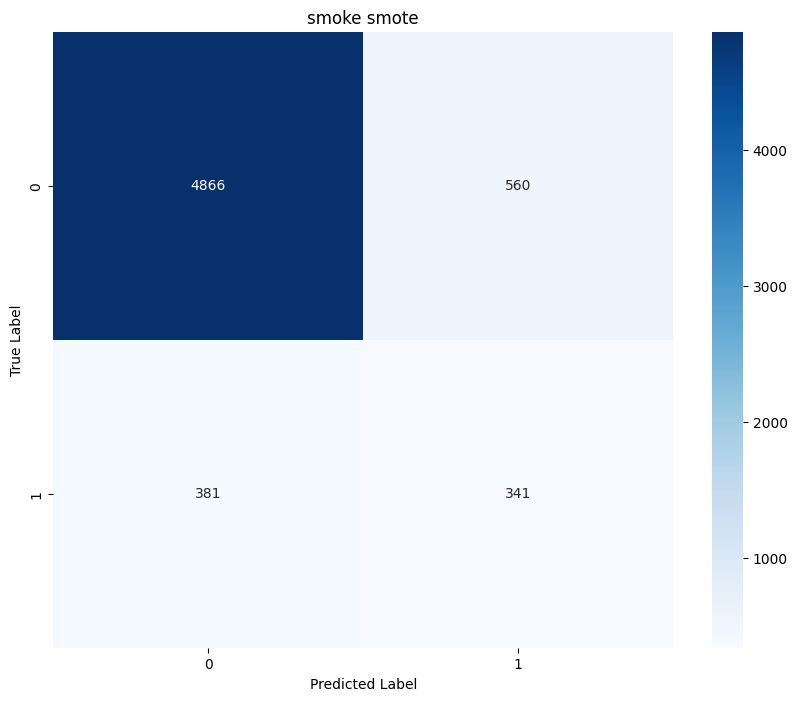

F1 Score: 0.8540989521572614

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      5426
         1.0       0.38      0.47      0.42       722

    accuracy                           0.85      6148
   macro avg       0.65      0.68      0.67      6148
weighted avg       0.86      0.85      0.85      6148



In [28]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 실제 레이블과 예측 레이블을 사용하여 Confusion Matrix를 계산합니다.
conf_matrix = confusion_matrix(y_val, test_pred_idx)

# F1 Score를 계산합니다.
f1 = f1_score(y_val, test_pred_idx, average='weighted')

# Confusion Matrix를 시각화합니다.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# 모델에 맞게 타이틀 변경하기
plt.title('smoke smote')
plt.show()

# 결과를 출력합니다.
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_val, test_pred_idx))